In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [178]:
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

files_id = {
    'mush_data':"1ErjUx-K9Az--O73ji-rwVPsmg0H9JFR6", #mushroom data train
    'test_mush_data':"1DflyaLjlyxNoebKHOSBqB0GkPe1z7qaf", #test data for mushrooms
    'ids_com':"1CsRSHVvnecwpTteh6kkKjwkqp3pThIHh" #ID for the commiting of the project

}

mush_data = pd.read_csv(gd_path(files_id['mush_data']), sep=",")
test_mush_data = pd.read_csv(gd_path(files_id['test_mush_data']), sep=",")
ids_com = pd.read_csv(gd_path(files_id['ids_com']), sep=",")
df = mush_data

# Pre-Processing Pipe

## Ordinary columns

This part was done by hands. Many Bothans died to bring us this information.

In [179]:
from sklearn.model_selection import train_test_split

# X and y creation
y = df.pop("poisonous")

# Feature Engineering
X = df.drop('Id', axis=1)

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [180]:
# building the pipeline
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

#  numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

onehot_cols = X_cat.columns.get_indexer(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'])

categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols)
    ]
)

categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    categorical_encoder 
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

# Modelling Pipe - 1

## Decisiontree - Creation

In [181]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              DecisionTreeClassifier(class_weight='balanced'))

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}


search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)


scores = {"dtree" : search.best_score_}

# After fitting the model
search.best_estimator_.threshold = 0.01  # Adjust the threshold as needed

scores

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'dtree': 0.9557620122899237}

## Decisiontree - Analysis

In [182]:

# Get predictions for the training and testing datasets
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.957
Testing Accuracy: 0.964 

Confusion Matrix (Training):
 [[2495  176]
 [  45 2483]] 

Confusion Matrix (Testing):
 [[634  37]
 [ 10 619]] 

F-Score:

Training Score: 0.957
Testing Score: 0.963 

Kappa-Score:

Training Score: 0.915
Testing Score: 0.928


In [183]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model 1 AUC score: 0.9581532215450526


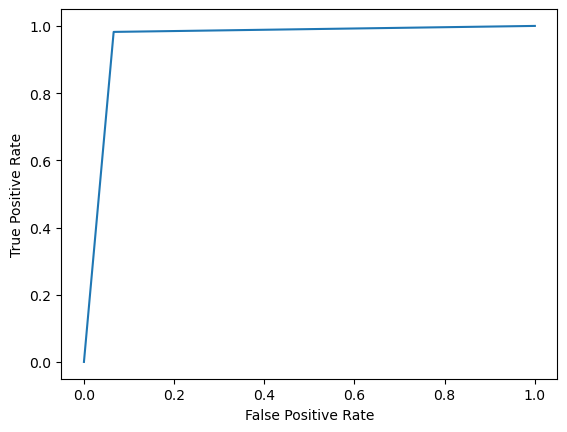

In [184]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

# Modeling Pipe - 2


In [185]:
# Modeling Pipe - 2

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


full_pipeline = make_pipeline(preprocessor,
                              KNeighborsClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(3, 20, 2)
}

search2 = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search2.fit(X_train, y_train)

# After fitting the model
search2.best_estimator_.threshold = 0.3  # Adjust the threshold as needed


scores2 = {"knn" : search.best_score_}

scores2


Fitting 10 folds for each of 18 candidates, totalling 180 fits


{'knn': 0.9557620122899237}

## Decisiontree - Analysis KNN

### Confusion Matrix

In [192]:
# Get predictions for the training and testing datasets
y_train_pred = search2.predict(X_train)
y_test_pred = search2.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.958
Testing Accuracy: 0.965 

Confusion Matrix (Training):
 [[2557  114]
 [ 106 2422]] 

Confusion Matrix (Testing):
 [[649  22]
 [ 24 605]] 

F-Score:

Training Score: 0.957
Testing Score: 0.963 

Kappa-Score:

Training Score: 0.915
Testing Score: 0.929


model 1 AUC score: 0.9581532215450526


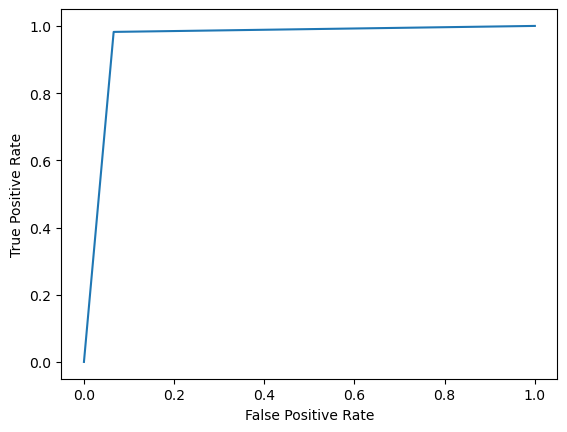

In [187]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

# Modelling Pipe - 3

## RandomForest- Creation

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor,
                              RandomForestClassifier())

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["median"],
    "randomforestclassifier__n_estimators": [200, 500],
    'randomforestclassifier__max_depth' : [4,5,6,7,8],
}

# need to be rearange 
search4 = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search4.fit(X_train, y_train)

# After fitting the model
search4.best_estimator_.threshold = 0.3  # Adjust the threshold as needed


scores4 = {"rf" : search4.best_score_}
print("Best parameters: ", search4.best_params_)
scores4

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'columntransformer__num_pipe__simpleimputer__strategy': 'median', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 500}


{'rf': 0.9436444066039831}

## RandomForest - Analysis

In [189]:
# Get predictions for the training and testing datasets
y_train_pred = search4.predict(X_train)
y_test_pred = search4.predict(X_test)

# Create confusion matrices
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

# Calculate accuracy for training and testing datasets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", round(accuracy_train,3))
print("Testing Accuracy:", round(accuracy_test,3),"\n")

print("Confusion Matrix (Training):\n", confusion_matrix_train,"\n")
print("Confusion Matrix (Testing):\n", confusion_matrix_test,"\n")

print("F-Score:\n")
print("Training Score:", round(f1_score(y_train,y_train_pred),3))
print("Testing Score:", round(f1_score(y_test,y_test_pred),3),"\n")

print("Kappa-Score:\n")
print("Training Score:", round(cohen_kappa_score(y_train,y_train_pred),3))
print("Testing Score:", round(cohen_kappa_score(y_test,y_test_pred),3))

Training Accuracy: 0.945
Testing Accuracy: 0.947 

Confusion Matrix (Training):
 [[2582   89]
 [ 199 2329]] 

Confusion Matrix (Testing):
 [[650  21]
 [ 48 581]] 

F-Score:

Training Score: 0.942
Testing Score: 0.944 

Kappa-Score:

Training Score: 0.889
Testing Score: 0.894


model 1 AUC score: 0.9439803959783706


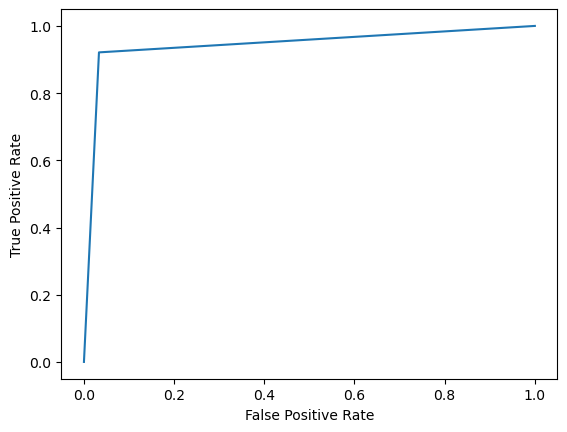

In [190]:
plot_roc_curve(y_train, y_train_pred)
print(f'model 1 AUC score: {roc_auc_score(y_train, y_train_pred)}')

## Downloand

In [191]:
X_sumbmition = test_mush_data
ids_com['poisonous'] = search.predict(X_sumbmition) # only cange the piplene! 
ids_com.to_csv(r'submission_5.csv', index=False) #only cahnge ist 